In [37]:
import torch
torch.__version__

'1.4.0'

# 2.5 循环神经网络
##  2.5.1 RNN简介
我们的大脑区别于机器的一个最大的特征就是我们有记忆，并且能够根据自己的记忆对未知的事务进行推导，我们的思想拥有持久性的。但是本教程目前所介绍的神经网络结构各个元素之间是相互独立的，输入与输出是独立的。
### RNN的起因
现实世界中，很多元素都是相互连接的，比如室外的温度是随着气候的变化而周期性的变化的、我们的语言也需要通过上下文的关系来确认所表达的含义。但是机器要做到这一步就相当得难了。因此，就有了现在的循环神经网络，他的本质是：拥有记忆的能力，并且会根据这些记忆的内容来进行推断。因此，他的输出就依赖于当前的输入和记忆。
### 为什么需要RNN
RNN背后的想法是利用顺序的信息。 在传统的神经网络中，我们假设所有输入（和输出）彼此独立。  如果你想预测句子中的下一个单词，你就要知道它前面有哪些单词，甚至要看到后面的单词才能够给出正确的答案。 
RNN之所以称为循环，就是因为它们对序列的每个元素都会执行相同的任务，所有的输出都取决于先前的计算。
从另一个角度讲RNN的它是有“记忆”的，可以捕获到目前为止计算的信息。 理论上，RNN可以在任意长的序列中使用信息，但实际上它们仅限于回顾几个步骤。
循环神经网络的提出便是基于记忆模型的想法，期望网络能够记住前面出现的特征.并依据特征推断后面的结果，而且整体的网络结构不断循环，因为得名循环神经网络。


### RNN都能做什么
RNN在许多NLP任务中取得了巨大成功。 在这一点上，我应该提到最常用的RNN类型是LSTM，它在捕获长期依赖性方面要比RNN好得多。 但不要担心，LSTM与我们将在本教程中开发的RNN基本相同，它们只是采用不同的方式来计算隐藏状态。 我们将在后面更详细地介绍LSTM。 以下是RNN在NLP中的一些示例：
**语言建模与生成文本**

我们通过语言的建模，可以通过给定的单词生成人类可以理解的以假乱真的文本

**机器翻译**

机器翻译类似于语言建模，我们的输入源语言中的一系列单词，通过模型的计算可以输出目标语言与之对应的内容。 

**语音识别**

给定来自声波的声学信号的输入序列，我们可以预测一系列语音片段及其概率，并把语音转化成文字

**生成图像描述**

与卷积神经网络一起，RNN可以生成未标记图像的描述。

## 2.5.2 RNN的网络结构及原理
### RNN
循环神经网络的基本结构特别简单，就是将网络的输出保存在一个记忆单元中，这个记忆单元和下一次的输入一起进入神经网络中。我们可以看到网络在输入的时候会联合记忆单元一起作为输入，网络不仅输出结果，还会将结果保存到记忆单元中，下图就是一个最简单的循环神经网络在输入时的结构示意图。[图片来源](https://medium.com/explore-artificial-intelligence/an-introduction-to-recurrent-neural-networks-72c97bf0912)

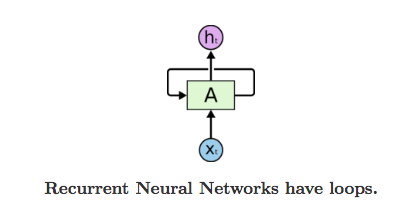
RNN 可以被看做是同一神经网络的多次赋值，每个神经网络模块会把消息传递给下一个，我们将这个图的结构展开
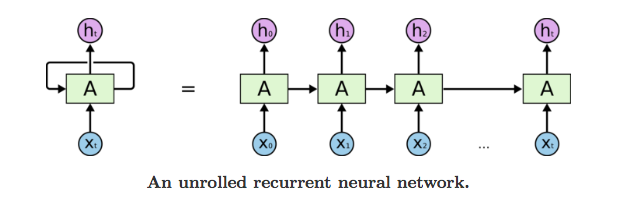
网络中具有循环结构，这也是循环神经网络名字的由来，同时根据循环神经网络的结构也可以看出它在处理序列类型的数据上具有天然的优势。因为网络本身就是 一个序列结构，这也是所有循环神经网络最本质的结构。

循环神经网络具有特别好的记忆特性，能够将记忆内容应用到当前情景下，但是网络的记忆能力并没有想象的那么有效。记忆最大的问题在于它有遗忘性，我们总是更加清楚地记得最近发生的事情而遗忘很久之前发生的事情，循环神经网络同样有这样的问题。

pytorch 中使用 nn.RNN 类来搭建基于序列的循环神经网络，它的构造函数有以下几个参数：
- input_size：输入数据X的特征值的数目。 
- hidden_size：隐藏层的神经元数量，也就是隐藏层的特征数量。
- num_layers：循环神经网络的层数，默认值是 1。 
- bias：默认为 True，如果为 false 则表示神经元不使用 bias 偏移参数。
- batch_first：如果设置为 True，则输入数据的维度中第一个维度就是 batch 值，默认为 False。默认情况下第一个维度是序列的长度， 第二个维度才是 - - batch，第三个维度是特征数目。
- dropout：如果不为空，则表示最后跟一个 dropout 层抛弃部分数据，抛弃数据的比例由该参数指定。

RNN 中最主要的参数是 input_size 和 hidden_size，这两个参数务必要搞清楚。其余的参数通常不用设置，采用默认值就可以了。

In [38]:
rnn = torch.nn.RNN(20, 50, 2)
input = torch.randn(100, 32, 20)
h_0 =torch.randn(2, 32 ,50)
output,hn=rnn(input, h_0) 
print(output.size(), hn.size())

torch.Size([100, 32, 50]) torch.Size([2, 32, 50])


初学者看到上面的介绍，肯定还是一头雾水，这些都是什么东西，在实际中如何使用？
下面我们通过pytorch来手写一个RNN的实现这样，通过自己的实现就会对RNN的结构有个更深入的了解了。

在实现之前，我们继续深入介绍一下RNN的工作机制，RNN其实也是一个普通的神经网络，只不过多了一个 hidden_state 来保存历史信息。这个hidden_state的作用就是为了保存以前的状态，我们常说RNN中保存的记忆状态信息，就是这个 hidden_state 。

对于RNN来说，我们只要己住一个公式：

$h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh}) $

这个公式来自官网：
https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN

这个公式里面的 $x_t$ 是我们当前状态的输入值，$h_{(t-1)}$ 就是上面说的要传入的上一个状态的hidden_state，也就是记忆部分。
整个网络要训练的部分就是 $W_{ih}$ 当前状态输入值的权重，$W_{hh}$ hidden_state也就是上一个状态的权重还有这两个输入偏置值。这四个值加起来使用tanh进行激活，pytorch默认是使用tanh作为激活，也可以通过设置使用relu作为激活函数。


上面讲的步骤就是用红框圈出的一次计算的过程
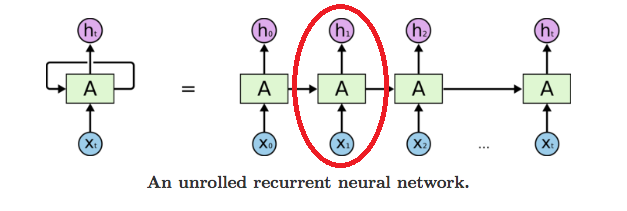

这个步骤与普通的神经网络没有任何的区别，而 RNN 因为多了 序列（sequence） 这个维度，要使用同一个模型跑 n 次前向传播，这个n就是我们序列设置的个数。
下面我们开始手动实现我们的RNN：参考的是karpathy大佬的文章：https://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [110]:
class RNN(object):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.W_xh = torch.nn.Linear(input_size, hidden_size) #因为最后的操作是相加 所以hidden要和output的shape一致
        self.W_hh = torch.nn.Linear(hidden_size, hidden_size)
        
    def __call__(self, x, hidden):
        return self.step(x, hidden)
    def step(self, x, hidden):
        #前向传播的一步
        h1 = self.W_hh(hidden)
        w1 = self.W_xh(x)
        out = torch.tanh(h1 + w1)
        hidden = self.W_hh.weight
        return out, hidden

In [111]:
rnn = RNN(20, 50)
input = torch.randn(32 , 20)
h_0 = torch.randn(32, 50) 
seq_len = input.shape[0]

In [112]:
for i in range(seq_len):
    output, hn = rnn(input[i, :], h_0)
print(output.size(), h_0.size())

torch.Size([32, 50]) torch.Size([32, 50])


### LSTM
LSTM 是 Long Short Term Memory Networks 的缩写，按字面翻译就是长的短时记忆网络。LSTM 的网络结构是 1997 年由 Hochreiter 和 Schmidhuber 提出的，随后这种网络结构变得非常流行。
LSTM虽然只解决了短期依赖的问题，并且它通过刻意的设计来避免长期依赖问题，这样的做法在实际应用中被证明还是十分有效的，有很多人跟进相关的工作解决了很多实际的问题，所以现在LSTM 仍然被广泛地使用。[图片来源](https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45)
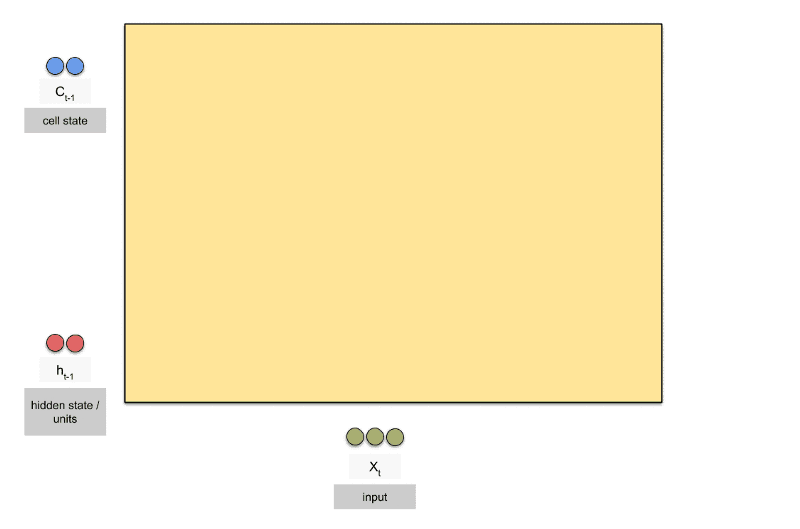
标准的循环神经网络内部只有一个简单的层结构，而 LSTM 内部有 4 个层结构：

第一层是个忘记层：决定状态中丢弃什么信息

第二层tanh层用来产生更新值的候选项，说明状态在某些维度上需要加强，在某些维度上需要减弱

第三层sigmoid层（输入门层），它的输出值要乘到tanh层的输出上，起到一个缩放的作用，极端情况下sigmoid输出0说明相应维度上的状态不需要更新

最后一层决定输出什么，输出值跟状态有关。候选项中的哪些部分最终会被输出由一个sigmoid层来决定。


pytorch 中使用 nn.LSTM 类来搭建基于序列的循环神经网络，他的参数基本与RNN类似，这里就不列出了。

In [61]:
lstm = torch.nn.LSTM(10, 20,2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, hn = lstm(input, (h0, c0))
print(output.size(), hn[0].size(), hn[1].size())

torch.Size([5, 3, 20]) torch.Size([2, 3, 20]) torch.Size([2, 3, 20])


### GRU

GRU 是 gated recurrent units 的缩写，由 Cho在 2014 年提出。GRU 和 LSTM 最大的不同在于 GRU 将遗忘门和输入门合成了一个"更新门"，同时网络不再额外给出记忆状态，而是将输出结果作为记忆状态不断向后循环传递，网络的输人和输出都变得特别简单。

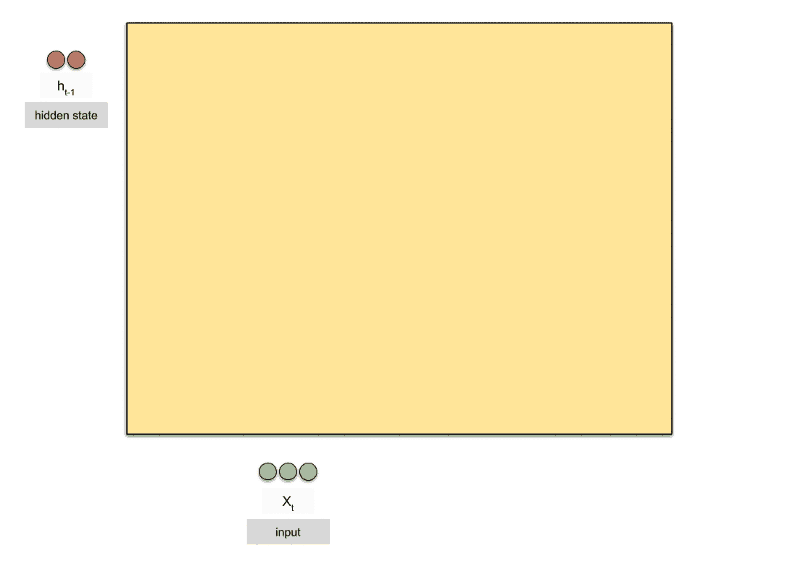

In [62]:
rnn = torch.nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h_0= torch.randn(2, 3, 20)
output, hn = rnn(input, h0)
print(output.size(),hn.size())

torch.Size([5, 3, 20]) torch.Size([2, 3, 20])


## 2.5.3 循环网络的向后传播（BPTT）
在向前传播的情况下，RNN的输入随着每一个时间步前进。在反向传播的情况下，我们“回到过去”改变权重，因此我们叫它通过时间的反向传播（BPTT）。

我们通常把整个序列（单词）看作一个训练样本，所以总的误差是每个时间步（字符）中误差的和。权重在每一个时间步长是相同的（所以可以计算总误差后一起更新）。
1. 使用预测输出和实际输出计算交叉熵误差
2. 网络按照时间步完全展开
3. 对于展开的网络，对于每一个实践步计算权重的梯度
4. 因为对于所有时间步来说，权重都一样，所以对于所有的时间步，可以一起得到梯度（而不是像神经网络一样对不同的隐藏层得到不同的梯度）
5. 随后对循环神经元的权重进行升级

RNN展开的网络看起来像一个普通的神经网络。反向传播也类似于普通的神经网络，只不过我们一次得到所有时间步的梯度。如果有100个时间步，那么网络展开后将变得非常巨大，所以为了解决这个问题才会出现LSTM和GRU这样的结构。


循环神经网络目前在自然语言处理中应用最为火热，所以后面的内容将介绍一下循环神经网络在处理NLP的时候需要用到的一些其他的知识

## 2.5.4 词嵌入（word embedding）
在我们人类交流过程中表征词汇是直接使用英文单词来进行表征的，但是对于计算机来说，是无法直接认识单词的。为了让计算机能够能更好地理解我们的语言，建立更好的语言模型，我们需要将词汇进行表征。

在图像分类问题会使用 one-hot 编码。比如LeNet中一共有10个数字0-9，如果这个数字是2的话类，它的编码就是 (0，0，1，0， 0，0 ，0，0，0，0)，对于分类问题这样表示十分的清楚，但是在自然语言处理中，因为单词的数目过多比如有 10000 个不同的词，那么使用 one-hot 这样的方式来定义，效率就特别低，每个单词都是 10000 维的向量。其中只有一位是 1 ， 其余都是 0，特别占用内存，而且也不能体现单词的词性，因为每一个单词都是 one-hot，虽然有些单词在语义上会更加接近.但是 one-hot 没办法体现这个特点，所以 必须使用另外一种方式定义每一个单词。

用不同的特征来对各个词汇进行表征，相对与不同的特征，不同的单词均有不同的值这就是词嵌入。下图还是来自吴恩达老师的课程截图
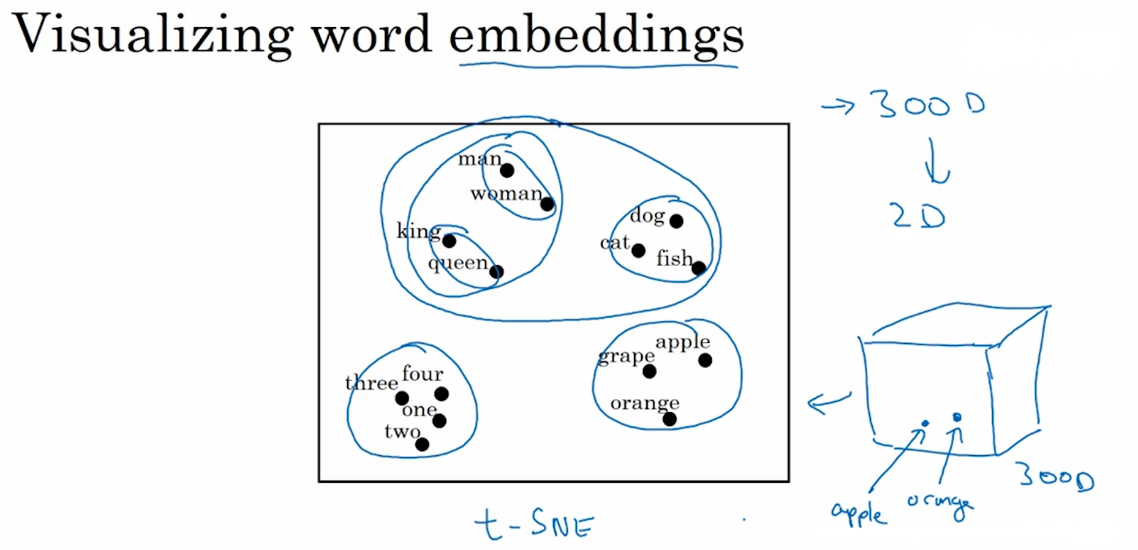

词嵌入不仅对不同单词实现了特征化的表示，还能通过计算词与词之间的相似度，实际上是在多维空间中，寻找词向量之间各个维度的距离相似度，我们就可以实现类比推理，比如说夏天和热，冬天和冷，都是有关联关系的。

在 PyTorch 中我们用 nn.Embedding 层来做嵌入词袋模型，Embedding层第一个输入表示我们有多少个词，第二个输入表示每一个词使用多少维度的向量表示。

In [5]:
# an Embedding module containing 10 tensors of size 3
embedding = torch.nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
output = embedding(input)
print(output.size())

torch.Size([2, 4, 3])


## 2.5.5  其他重要概念

### Beam search
在生成第一个词的分布后，可以使用贪心搜索会根据我们的条件语言模型挑选出最有可能输出的第一个词语，但是对于贪心搜索算法来说，我们的单词库中有成百到千万的词汇，去计算每一种单词的组合的可能性是不可行的。所以我们使用近似的搜索办法，使得条件概率最大化或者近似最大化的句子，而不是通过单词去实现。

Beam Search（集束搜索）是一种启发式图搜索算法，通常用在图的解空间比较大的情况下，为了减少搜索所占用的空间和时间，在每一步深度扩展的时候，剪掉一些质量比较差的结点，保留下一些质量较高的结点。虽然Beam Search算法是不完全的，但是用于了解空间较大的系统中，可以减少空间占用和时间。

Beam search可以看做是做了约束优化的广度优先搜索，首先使用广度优先策略建立搜索树，树的每层，按照启发代价对节点进行排序，然后仅留下预先确定的个数（Beam width-集束宽度）的节点，仅这些节点在下一层次继续扩展，其他节点被剪切掉。
1. 将初始节点插入到list中
2. 将给节点出堆，如果该节点是目标节点，则算法结束；
3. 否则扩展该节点，取集束宽度的节点入堆。然后到第二步继续循环。
4. 算法结束的条件是找到最优解或者堆为空。

在使用上，集束宽度可以是预先约定的，也可以是变化的，具体可以根据实际场景调整设定。


### 注意力模型
对于使用编码和解码的RNN模型，我们能够实现较为准确度机器翻译结果。对于短句子来说，其性能是十分良好的，但是如果是很长的句子，翻译的结果就会变差。
我们人类进行人工翻译的时候，都是一部分一部分地进行翻译，引入的注意力机制，和人类的翻译过程非常相似，其也是一部分一部分地进行长句子的翻译。

具体的内容在这里就不详细介绍了
